In [1]:
import torch
import torchvision
from matplotlib import pyplot as plt

In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

device

device(type='cuda')

In [3]:
NUM_CLASSES = 10
BATCH_SIZE = 16

IMAGENETTE_LABELS = {
    0: 'tench',
    1: 'English springer',
    2: 'cassette player',
    3: 'chain saw',
    4: 'church',
    5: 'French horn',
    6: 'garbage truck',
    7: 'gas pump',
    8: 'golf ball',
    9: 'parachute',
}

transforms = torchvision.transforms.Compose([
    torchvision.transforms.Resize((224, 224)),
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize(mean=[0.485, 0.456, 0.406],std=[0.229, 0.224, 0.225]),
])

imagenette_train = torchvision.datasets.Imagenette(
    './data/imagenette',
    split='train',
    download=True,
    transform=transforms,
)

imagenette_test = torchvision.datasets.Imagenette(
    './data/imagenette',
    split='val',
    download=True,
    transform=transforms,
)

imagenette_train_dataloader = torch.utils.data.DataLoader(
    imagenette_train,
    batch_size=BATCH_SIZE,
    shuffle=True,
    drop_last=True,
)

imagenette_test_dataloader = torch.utils.data.DataLoader(
    imagenette_test,
    batch_size=BATCH_SIZE,
    shuffle=False,
)

In [4]:
model = torchvision.models.resnet34(weights=torchvision.models.ResNet34_Weights)

model.fc

/home/stepan/Private/fine_tune_resnet/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet34_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet34_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Linear(in_features=512, out_features=1000, bias=True)

In [5]:
model.fc = torch.nn.Linear(in_features=model.fc.in_features, out_features=NUM_CLASSES)
model = model.to(device)

model.fc

Linear(in_features=512, out_features=10, bias=True)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.64].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.9295317..2.3959913].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.1007793..2.5877128].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.64].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.0182073..2.622571].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.8781574..2.465708].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.0836544..2.535425].


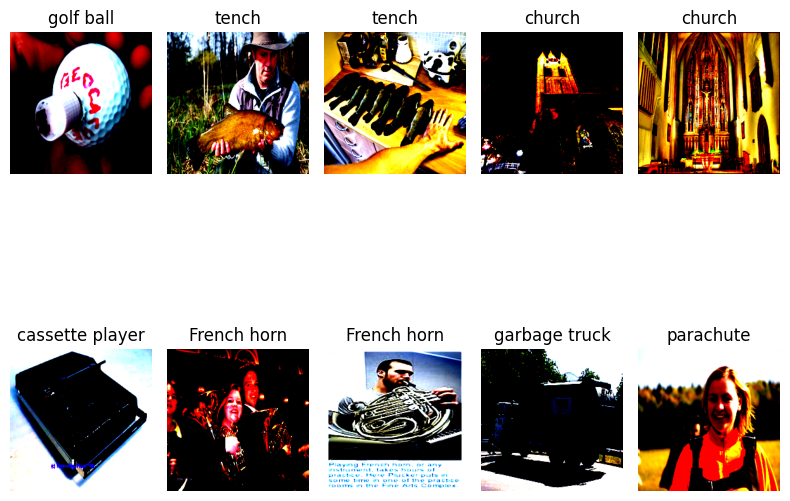

In [6]:
fig = plt.figure(figsize=(8, 8))

for i in range(10):
    index = torch.randint(0, len(imagenette_train) - 1, (1,)).item()
    image, c = imagenette_train[index]
    fig.add_subplot(2, 5, i % 10 + 1)
    plt.imshow(image.permute(1, 2, 0))
    plt.title(IMAGENETTE_LABELS[c])
    plt.axis('off')

plt.tight_layout()
plt.show()

In [7]:
def train(
    model,
    dataloader,
    loss_fn,
    optimizer,
    epoch,
    device,
):
    last_loss = 0
    running_loss = 0
    correct = 0

    model.train()

    for index, (data, labels) in enumerate(dataloader):
        data, labels = data.to(device), labels.to(device)

        optimizer.zero_grad()

        outputs = model(data)

        loss = loss_fn(outputs, labels)

        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        correct += (torch.max(outputs, 1)[1] == labels).float().sum()

        if index % 100 == 0:
            last_loss = running_loss / 100
            running_loss = 0

            print(f"Log: Epoch {epoch}, batch {index}, accuracy {correct / (len(dataloader) * BATCH_SIZE)}")

    return {
        'loss': last_loss,
        'accuracy': (correct / (len(dataloader) * BATCH_SIZE)).item()
    }
        

In [8]:
EPOCHS = 3

loss_fn = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)

train_results = []

for i in range(EPOCHS):
    epoch = i + 1
    result = train(model, imagenette_train_dataloader, loss_fn, optimizer, epoch, device)
    train_results.append(result)

Log: Epoch 1, batch 0, accuracy 0.0
Log: Epoch 1, batch 100, accuracy 0.15090946853160858
Log: Epoch 1, batch 200, accuracy 0.3076353669166565
Log: Epoch 1, batch 300, accuracy 0.46647629141807556
Log: Epoch 1, batch 400, accuracy 0.6246827244758606
Log: Epoch 1, batch 500, accuracy 0.7820431590080261
Log: Epoch 2, batch 0, accuracy 0.001692047342658043
Log: Epoch 2, batch 100, accuracy 0.16656090319156647
Log: Epoch 2, batch 200, accuracy 0.3318527936935425
Log: Epoch 2, batch 300, accuracy 0.4968273937702179
Log: Epoch 2, batch 400, accuracy 0.6630710363388062
Log: Epoch 2, batch 500, accuracy 0.8279399275779724
Log: Epoch 3, batch 0, accuracy 0.001692047342658043
Log: Epoch 3, batch 100, accuracy 0.16825295984745026
Log: Epoch 3, batch 200, accuracy 0.33396783471107483
Log: Epoch 3, batch 300, accuracy 0.500634491443634
Log: Epoch 3, batch 400, accuracy 0.6658206582069397
Log: Epoch 3, batch 500, accuracy 0.8311125040054321


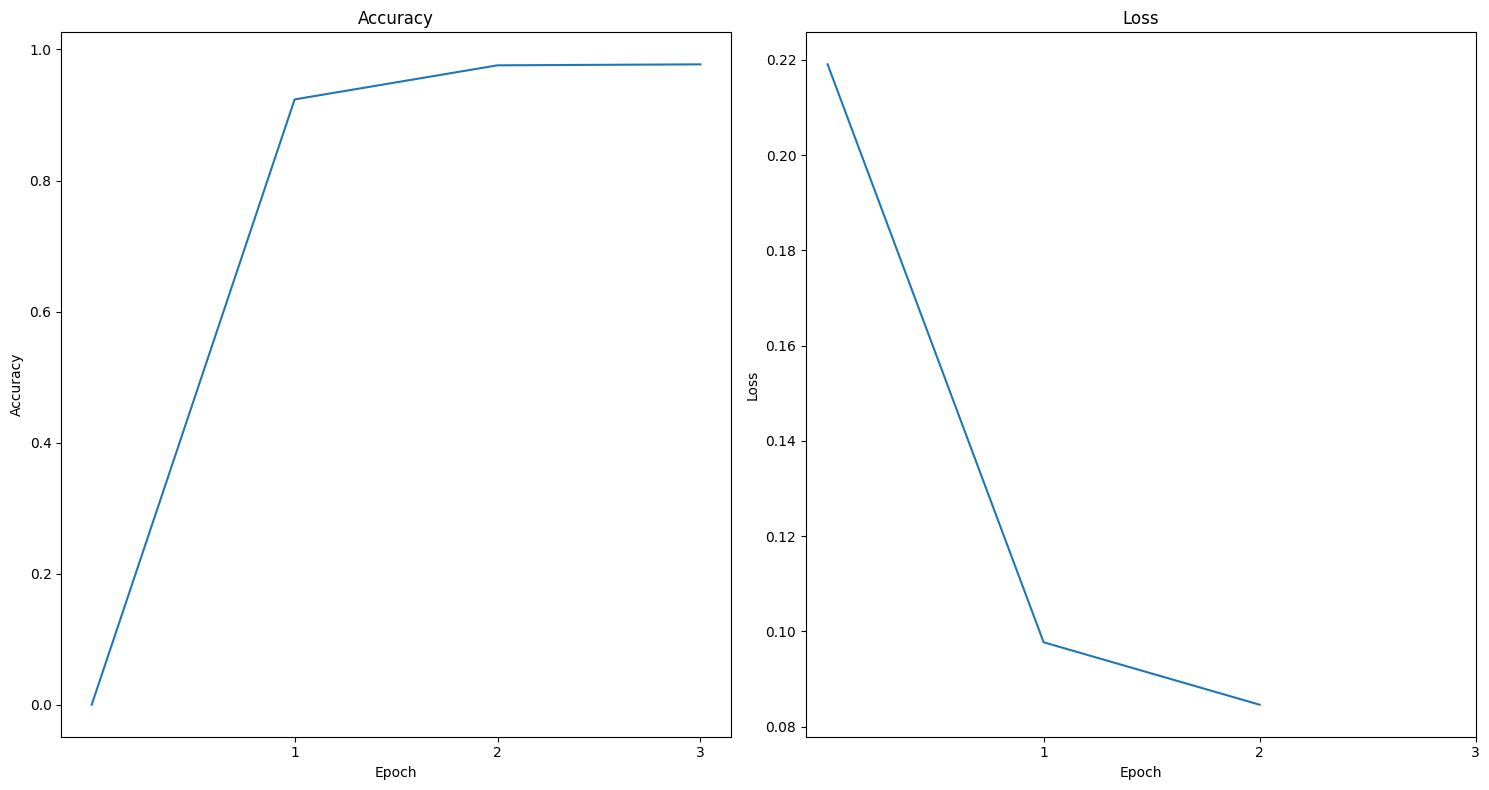

In [9]:
def plot_report(results):
    fig = plt.figure(figsize=(15, 8))
    fig.subplots_adjust(wspace=0.4, bottom=0.3)

    ax1 = fig.add_subplot(1, 2, 1)
    ax1.set_title('Accuracy')
    ax1.plot([0] + [result['accuracy'] for result in results])
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Accuracy')
    ax1.set_xticks([x + 1 for x in range(EPOCHS)])

    ax2 = fig.add_subplot(1, 2, 2)
    ax2.set_title('Loss')
    ax2.plot([result['loss'] for result in results])
    ax2.set_xlabel('Epoch')
    ax2.set_ylabel('Loss')
    ax2.set_xticks([x + 1 for x in range(EPOCHS)])

    plt.tight_layout()
    plt.show()

plot_report(train_results)

In [10]:
def evaluate(
    model,
    dataloader,
    loss_fn,
    device,
):
    last_loss = 0
    running_loss = 0
    correct = 0

    model.eval()

    with torch.no_grad():
        for index, (data, labels) in enumerate(dataloader):
            data, labels = data.to(device), labels.to(device)

            outputs = model(data)

            _, pred = torch.max(outputs, 1)

            loss = loss_fn(outputs, labels)

            running_loss += loss.item()
            correct += (pred == labels).float().sum()

            if index % 100 == 0:
                last_loss = running_loss / 100

                running_accuracy = (correct / (len(dataloader) * BATCH_SIZE)).item()

                print(f"Log: accuracy {running_accuracy}, loss {running_loss}")

                running_loss = 0

    return {
        'accuracy': (correct / (len(dataloader) * BATCH_SIZE)).item(),
        'loss': last_loss,
    }

In [11]:
test_result = evaluate(model, imagenette_test_dataloader, loss_fn, device)

test_result

Log: accuracy 0.004065040498971939, loss 0.021587520837783813
Log: accuracy 0.3859247863292694, loss 19.60318648998509
Log: accuracy 0.775660514831543, loss 14.710011326009408


{'accuracy': 0.9471544623374939, 'loss': 0.1471001132600941}

In [12]:
imagenette_trained_fc = model.fc

imagenette_trained_fc

Linear(in_features=512, out_features=10, bias=True)

In [13]:
CIFAR10_LABELS = {
    0: 'airplane',
    1: 'automobile',
    2: 'bird',
    3: 'cat',
    4: 'deer',
    5: 'dog',
    6: 'frog',
    7: 'horse',
    8: 'ship',
    9: 'truck',
}

cifar10_train = torchvision.datasets.CIFAR10(
    './data/cifar10',
    train=True,
    download=True,
    transform=transforms,
)

cifar10_test = torchvision.datasets.CIFAR10(
    './data/cifar10',
    train=False,
    download=True,
    transform=transforms,
)

cifar10_train_dataloader = torch.utils.data.DataLoader(
    cifar10_train,
    batch_size=BATCH_SIZE,
    shuffle=True,
    drop_last=True,
)

cifar10_test_dataloader = torch.utils.data.DataLoader(
    cifar10_test,
    batch_size=BATCH_SIZE,
    shuffle=False,
)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.8256302..2.5005665].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.0322802..2.0822659].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.9637812..2.1519828].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.5877128].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.3088455].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.0182073..2.622571].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.5081482..

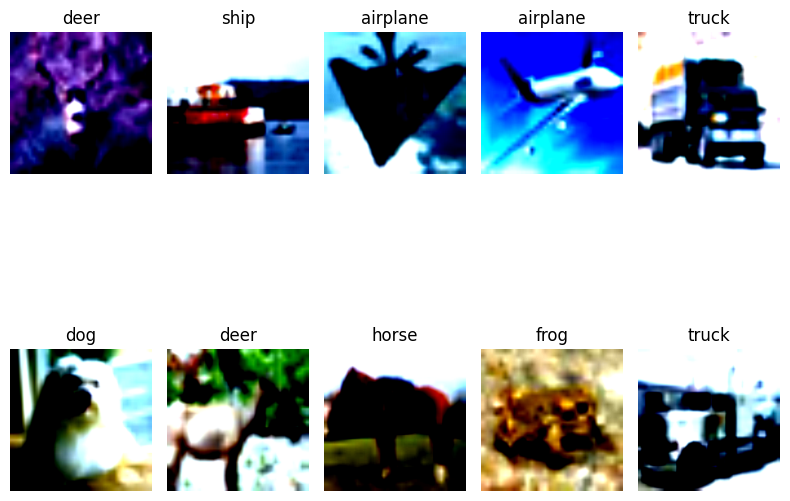

In [14]:
fig = plt.figure(figsize=(8, 8))

for i in range(10):
    index = torch.randint(0, len(cifar10_train) - 1, (1,)).item()
    image, c = cifar10_train[index]
    fig.add_subplot(2, 5, i % 10 + 1)
    plt.imshow(image.permute(1, 2, 0))
    plt.title(CIFAR10_LABELS[c])
    plt.axis('off')

plt.tight_layout()
plt.show()

In [15]:
train_results = []

for i in range(1):
    epoch = i + 1
    result = train(model, cifar10_train_dataloader, loss_fn, optimizer, epoch, device)
    train_results.append(result)

Log: Epoch 1, batch 0, accuracy 3.9999998989515007e-05
Log: Epoch 1, batch 100, accuracy 0.014919999986886978
Log: Epoch 1, batch 200, accuracy 0.0363599993288517
Log: Epoch 1, batch 300, accuracy 0.060339998453855515
Log: Epoch 1, batch 400, accuracy 0.08517999947071075
Log: Epoch 1, batch 500, accuracy 0.11051999777555466
Log: Epoch 1, batch 600, accuracy 0.13672000169754028
Log: Epoch 1, batch 700, accuracy 0.16303999722003937
Log: Epoch 1, batch 800, accuracy 0.18969999253749847
Log: Epoch 1, batch 900, accuracy 0.21661999821662903
Log: Epoch 1, batch 1000, accuracy 0.24395999312400818
Log: Epoch 1, batch 1100, accuracy 0.271699994802475
Log: Epoch 1, batch 1200, accuracy 0.29857999086380005
Log: Epoch 1, batch 1300, accuracy 0.3260999917984009
Log: Epoch 1, batch 1400, accuracy 0.3541399836540222
Log: Epoch 1, batch 1500, accuracy 0.3822399973869324
Log: Epoch 1, batch 1600, accuracy 0.41001999378204346
Log: Epoch 1, batch 1700, accuracy 0.43821999430656433
Log: Epoch 1, batch 180

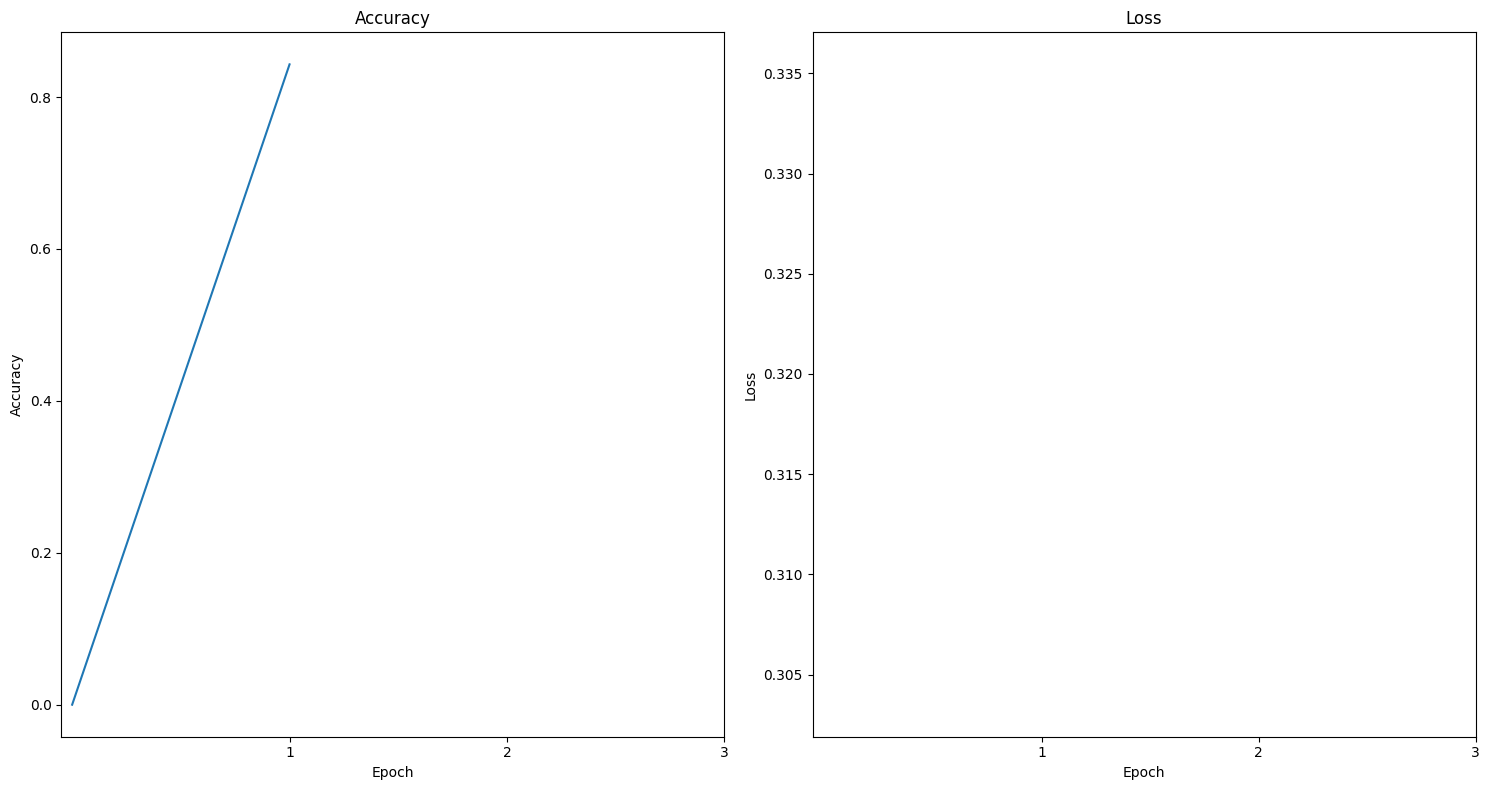

In [16]:
plot_report(train_results)

In [17]:
test_result = evaluate(model, cifar10_test_dataloader, loss_fn, device)

test_result

Log: accuracy 0.0015999999595806003, loss 0.11720781773328781
Log: accuracy 0.14839999377727509, loss 23.472520077601075
Log: accuracy 0.29600000381469727, loss 24.877942375838757
Log: accuracy 0.44419997930526733, loss 23.10657585412264
Log: accuracy 0.5906000137329102, loss 25.581328680738807
Log: accuracy 0.7353999614715576, loss 28.800941882655025
Log: accuracy 0.8812999725341797, loss 26.15061834640801


{'accuracy': 0.9154999852180481, 'loss': 0.2615061834640801}

In [18]:
model.fc = torch.nn.Linear(in_features=imagenette_trained_fc.in_features, out_features=NUM_CLASSES)
model.fc = model.fc.cuda()
model.fc

Linear(in_features=512, out_features=10, bias=True)

In [19]:
test_result = evaluate(model, imagenette_test_dataloader, loss_fn, device)

test_result

Log: accuracy 0.0007621950935572386, loss 2.0599656105041504
Log: accuracy 0.04801829159259796, loss 223.01024556159973
Log: accuracy 0.15193088352680206, loss 226.8789849281311


{'accuracy': 0.15193088352680206, 'loss': 2.268789849281311}

In [20]:
for param in model.parameters():
    param.requires_grad = False

model.fc = imagenette_trained_fc

assert model.fc.weight.requires_grad is True

model.fc

Linear(in_features=512, out_features=10, bias=True)

In [21]:
train_results = []

for i in range(EPOCHS):
    epoch = i + 1
    result = train(model, imagenette_train_dataloader, loss_fn, optimizer, epoch, device)
    train_results.append(result)

Log: Epoch 1, batch 0, accuracy 0.00010575295891612768
Log: Epoch 1, batch 100, accuracy 0.018824025988578796
Log: Epoch 1, batch 200, accuracy 0.06408629566431046
Log: Epoch 1, batch 300, accuracy 0.1449873000383377
Log: Epoch 1, batch 400, accuracy 0.23307952284812927
Log: Epoch 1, batch 500, accuracy 0.33037224411964417
Log: Epoch 2, batch 0, accuracy 0.0011632825480774045
Log: Epoch 2, batch 100, accuracy 0.10670473426580429
Log: Epoch 2, batch 200, accuracy 0.214043989777565
Log: Epoch 2, batch 300, accuracy 0.3205372095108032
Log: Epoch 2, batch 400, accuracy 0.4297800362110138
Log: Epoch 2, batch 500, accuracy 0.5410321354866028
Log: Epoch 3, batch 0, accuracy 0.0011632825480774045
Log: Epoch 3, batch 100, accuracy 0.11262690275907516
Log: Epoch 3, batch 200, accuracy 0.22377325594425201
Log: Epoch 3, batch 300, accuracy 0.33576563000679016
Log: Epoch 3, batch 400, accuracy 0.451565146446228
Log: Epoch 3, batch 500, accuracy 0.5702199339866638


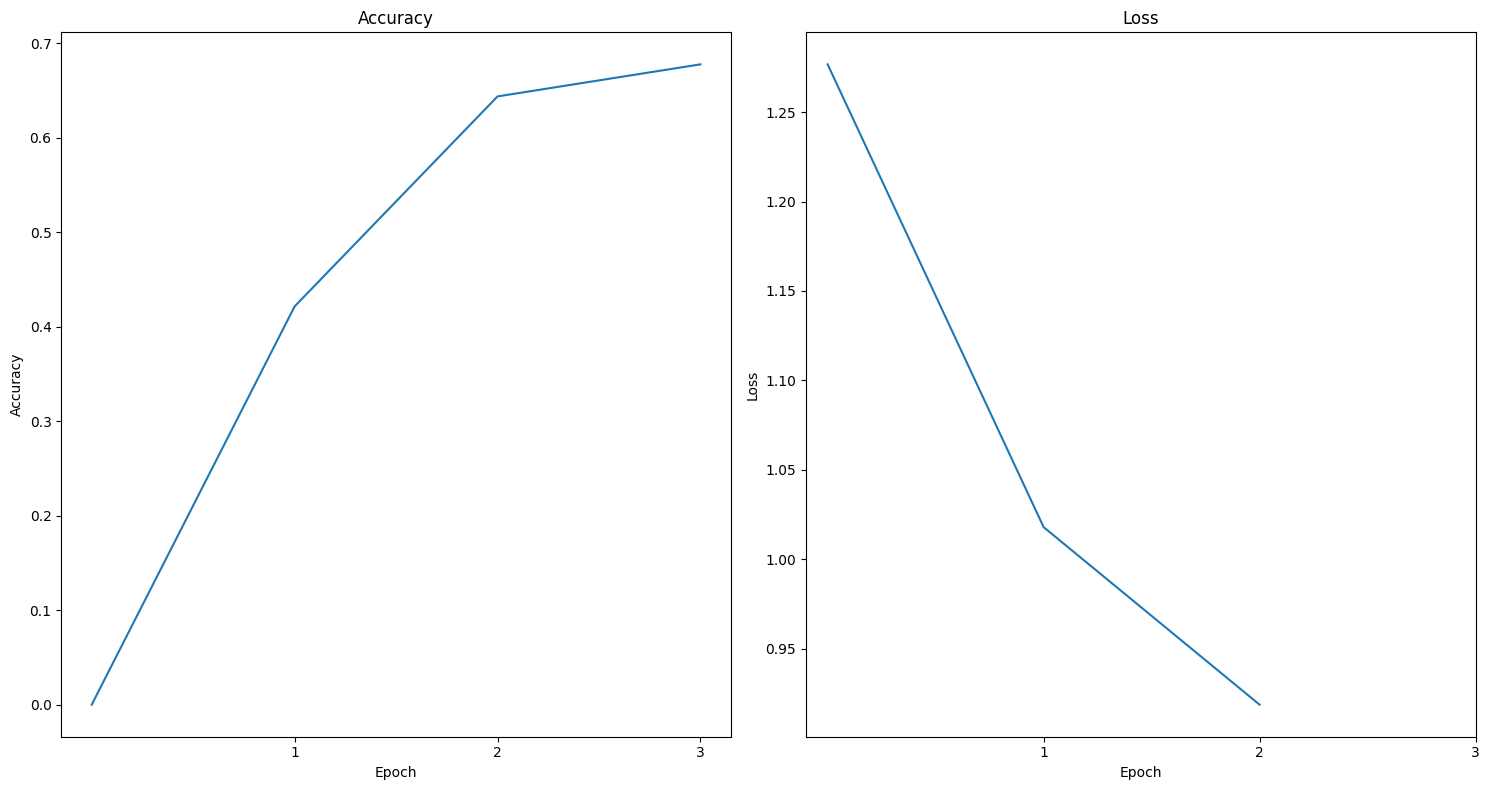

In [22]:
plot_report(train_results)

In [23]:
test_result = evaluate(model, imagenette_test_dataloader, loss_fn, device)

test_result

Log: accuracy 0.0035569104366004467, loss 0.7152766585350037
Log: accuracy 0.27337396144866943, loss 96.71776233613491
Log: accuracy 0.5752032399177551, loss 85.88826467096806


{'accuracy': 0.7080792188644409, 'loss': 0.8588826467096805}

We can observe that when fine-tuning a model without freezing the hidden layers on a dataset Imagenette, then the accuracy is about 0.95.

When we re-evaluate a model on re-trained version of it on CIFAR10, then the quality is 0.91.

When re-using the fully connected classifier from base version but re-evaluating on Imagenette, then we observe the catastrophic forgetting effect, the accuracy is around 0.15.

If we re-train the same model on Imagenette but freeze the hidden layers, then we can see the accuracy is 0.70 that's higher that in previous experiment but still lower than the baseline.